In [1]:
import os
import gc
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties

from functions.mandyocIO import read_mandyoc_output, read_datasets, read_particle_path

# Initial setup

In [2]:
# Path to the model directory
model_path = "/home/kugelblitz/runs/strak_36"

read_ascii = False # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
plot_first = True # Generate and plot only the first image
save_images = False # Generate and save all the possible images
follow_particle = True # Stores x and z position of a particle through the simulation
make_video = False # Make video witll all the possible imagesTrue

# Datasets handeling
## Model path

In [3]:
# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")
if not os.path.isdir(output_path):
    os.makedirs(output_path)

model_name = os.path.split(model_path)[1]

datasets = ("temperature", "viscosity", "strain_rate", "surface", "velocity", "density")

### Read ascii outputs and save them as xarray.Datasets

In [4]:
# Read data and convert them to xarray.Dataset
if (read_ascii):
    ds_data = read_mandyoc_output(
        model_path,
        datasets=datasets,
        parameters_file="param.txt"
    )

In [5]:
if (follow_particle):    
    particle_x, particle_z, particle_ID = read_particle_path(
        model_path,
        (2_250.0e3, -80.0e3),
        unit_number=np.nan,
        ncores=np.nan
    )

Finding closest point to x: 2250000.0 [m] and z: -80000.0 [m]...
Found point with ID: 5023559.0, x: 2250360.0 [m], z: -77477.2 [m]
Reading step files... Step files read.


X displacement: 28660.0 [m]


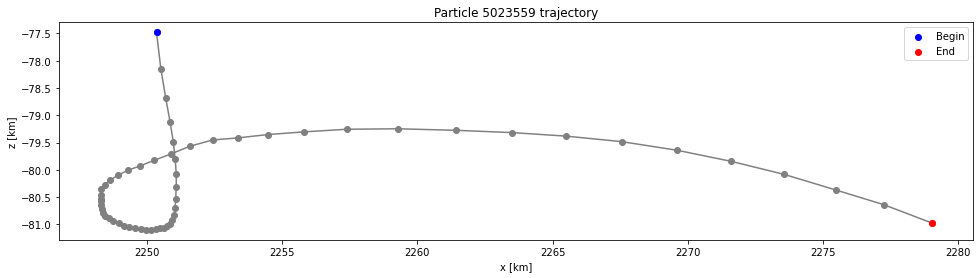

In [6]:
if (follow_particle):
    x_disp = abs(particle_x[-1] - particle_x[0])
    z_disp = abs(particle_z[-1] - particle_z[0])
    print("X displacement:", x_disp, "[m]")
    plt.figure(figsize=(x_disp*2/z_disp, 4), facecolor="white")
    plt.title(f'Particle {int(particle_ID)} trajectory')
    plt.plot(particle_x/1.0e3, particle_z/1.0e3, color='grey')
    plt.scatter(particle_x/1.0e3, particle_z/1.0e3, color='grey')
    plt.scatter(particle_x[0]/1.0e3, particle_z[0]/1.0e3, color='blue', label='Begin', zorder=10) # zorder must be big to be on top of the other plots
    plt.scatter(particle_x[-1]/1.0e3, particle_z[-1]/1.0e3, color='red', label='End', zorder=10)
    plt.legend()
    plt.xlabel("x [km]")
    plt.ylabel("z [km]")
    plt.savefig(f"{output_path}/{model_name}_output_trajectory.png", dpi=300)

## Read and merge saved datasets into a single dataset

In [7]:
if (save_images) or (plot_first):
    dataset = read_datasets(model_path, datasets)

    # Normalize velocity values
    if ("velocity_x" and "velocity_x") in dataset.data_vars:
        v_max = np.max((dataset.velocity_x**2 + dataset.velocity_z**2)**(0.5))    
        dataset.velocity_x[:] = dataset.velocity_x[:] / v_max
        dataset.velocity_z[:] = dataset.velocity_z[:] / v_max

    print(dataset)

<xarray.Dataset>
Dimensions:      (x: 801, z: 161, time: 59)
Coordinates:
  * x            (x) float64 0.0 6.25e+03 1.25e+04 ... 4.988e+06 4.994e+06 5e+06
  * z            (z) float64 -1.04e+06 -1.034e+06 -1.027e+06 ... -6.5e+03 0.0
  * time         (time) float64 0.0 0.001515 0.003501 ... 1.949 2.049 2.149
    step         (time) int32 0 10 20 30 40 50 60 ... 530 540 550 560 570 580
Data variables:
    temperature  (time, x, z) float64 ...
    viscosity    (time, x, z) float64 ...
    strain_rate  (time, x, z) float64 ...
    surface      (time, x) float64 ...
    velocity_x   (time, x, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    velocity_z   (time, x, z) float64 0.0 1.525e-05 3.051e-05 ... 8.057e-06 0.0
    density      (time, x, z) float64 ...
Attributes: (12/86)
    nx:                                801
    nz:                                161
    lx:                                5000000.0
    lz:                                1040000.0
    solver:                 

# Generate and save output images

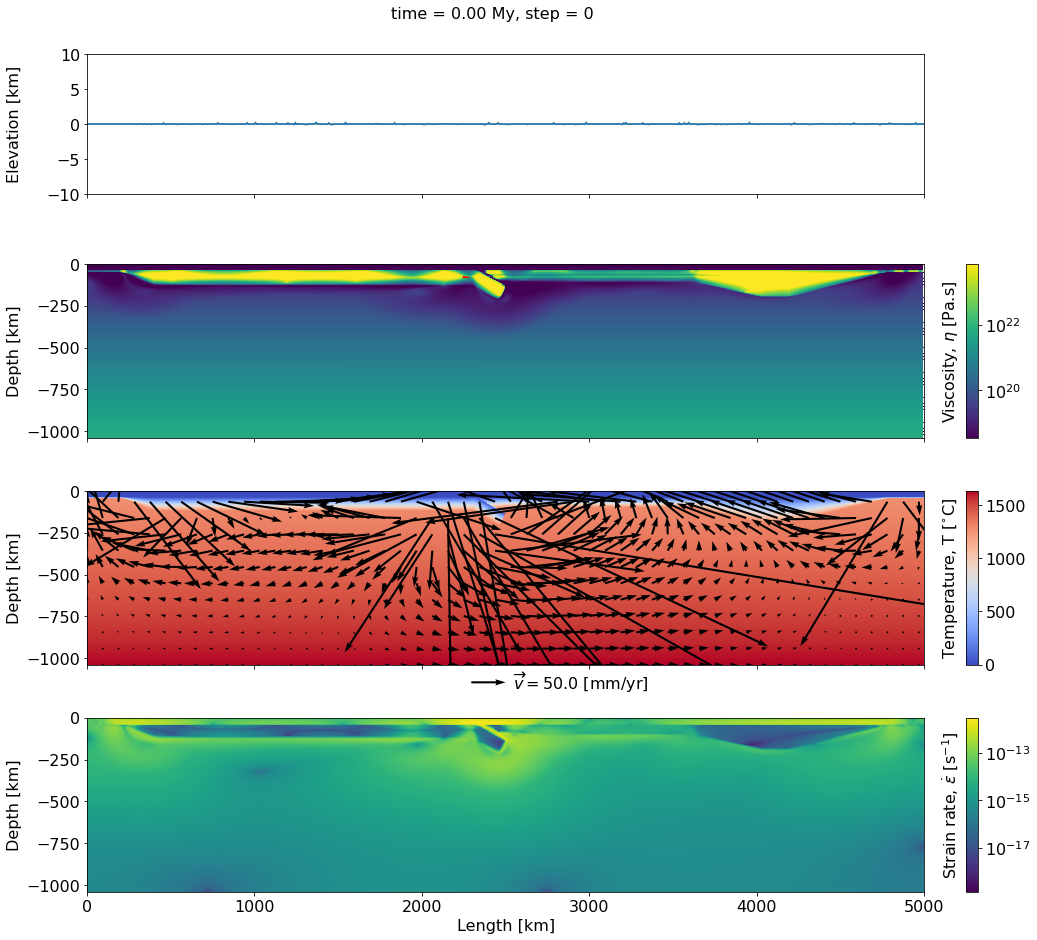

In [8]:
if (save_images) or (plot_first):
    aux = 0
    if ("temperature" or ("velocity_x" and "velocity_x")) in dataset.data_vars:
        aux += 1
        if "temperature" in dataset.data_vars:
            t_min = dataset.temperature.min() 
            t_max = dataset.temperature.max()
        if ("velocity_x" and "velocity_x") in dataset.data_vars:
            to_mm_yr = 365 * 24 * 60 * 60 * 1000.0
            desired_mm_per_year_value = 50.0
            v_key = desired_mm_per_year_value / to_mm_yr / v_max
            v_scale = 0.25 # If set to <n>, max velocity arrows will have the size of dataset.x.max()/<n>
    if "strain_rate" in dataset.data_vars:
        e_min, e_max = dataset.strain_rate.min(), dataset.strain_rate.max()
        aux += 1
    if "viscosity" in dataset.data_vars:
        eta_min, eta_max = float(dataset.attrs["viscosity_min"]), float(dataset.attrs["viscosity_max"])
        aux += 1
    if "surface" in dataset.data_vars:
        w_min, w_max = -10, 10 # dataset.surface.min()/1.0e3, dataset.surface.max()/1.0e3
        aux += 1

    aux_size_x = np.round(float(abs(dataset.x[-1]/1.0e6)), 1)
    aux_size_z = np.round(float(abs(dataset.z[0]/1.0e6)), 1)

    SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 16, 16, 16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    hspace = 0.2

    start = 0
    end = dataset.time.size - 1
    step = 1
    
    if (plot_first):
        start = 0
        end = 1
        step = 1

    # Corrects an unintended fontsize on the first run for the quiverkey
    quiverkey_font = FontProperties()
    quiverkey_font.set_size(MEDIUM_SIZE)

    for i in range(start, end, step):
        subplot_num = 0
        per = np.round(100*(i+1-start)/(end-start), 2)
        print(f'output {i}/{end-1}, {per:.2f}%', end='\r')

        data = dataset.isel(time=i)

        fig, axs = plt.subplots(aux, 1, figsize=(3*aux_size_x, aux*4*aux_size_z), sharex=True, facecolor="white")
        fig.subplots_adjust(hspace=hspace)

        if "surface" in dataset.data_vars:
            if (i == 0) or (start != 0): 
                data_0 = dataset.isel(time=0)
                h_air = np.round(np.mean(data_0.surface/1.0e3)) # Estimates air layer thickness based on the first step
            im = axs[subplot_num].hlines(0, data.surface.x[0]/1.0e3, data.surface.x[-1]/1.0e3, linestyle="solid", color="grey")
            im = axs[subplot_num].plot(data.surface.x/1.0e3, data.surface/1.0e3 - h_air)
            axs[subplot_num].set_ylim(-10, 10)
            axs[subplot_num].set_ylim(w_min, w_max)
            axs[subplot_num].set_ylabel("Elevation [km]")
            surface_subplot_num = subplot_num
            imshow_box = np.array(axs[subplot_num].get_position()) # Backup Bbox to be used if no other data_vars is in the xarray.Dataset
            subplot_num += 1

        if "viscosity" in dataset.data_vars:
            im = axs[subplot_num].imshow(data.viscosity.T[::-1], 
                                         extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3], 
                                         norm=LogNorm(vmin=eta_min, vmax=eta_max),
                                         cmap="viridis")
            cax = inset_axes(axs[subplot_num], 
                             width="5%", 
                             height="100%", 
                             loc='center left', 
                             bbox_to_anchor=(1.05, 0., 0.3, 1), 
                             bbox_transform=axs[subplot_num].transAxes, 
                             borderpad=0)
            axs[subplot_num].set_aspect("equal")
            axs[subplot_num].set_ylabel("Depth [km]")
            cbar = fig.colorbar(im, cax=cax)
            cbar.set_label('Viscosity, $\eta$ [Pa.s]', rotation=90, labelpad=-80)
            imshow_box = np.array(axs[subplot_num].get_position())
            im = axs[subplot_num].plot(particle_x/1.0e3, particle_z/1.0e3, color="red")
            subplot_num += 1

        if ("temperature" or ("velocity_x" and "velocity_x")) in dataset.data_vars:
            if "temperature" in dataset.data_vars:
                im = axs[subplot_num].imshow(data.temperature.T[::-1], 
                                             extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3], 
                                             vmin=t_min, vmax=t_max, 
                                             cmap="coolwarm")
                cax = inset_axes(axs[subplot_num], 
                                 width="5%", 
                                 height="100%", 
                                 loc='center left', 
                                 bbox_to_anchor=(1.05, 0., 0.3, 1), 
                                 bbox_transform=axs[subplot_num].transAxes, 
                                 borderpad=0)
                cbar = fig.colorbar(im, cax=cax)
                cbar.set_label(r'Temperature, T [$^{\circ}$C]', rotation=90, labelpad=-85)
            if ("velocity_x" and "velocity_x") in dataset.data_vars:
                num_vectors = 15
                vel_aux = data[dict(x=slice(None, None, num_vectors), z=slice(None, None, num_vectors))]
                v_label = '$\overrightarrow{v} =$' + f'{np.round(float(v_key*v_max*to_mm_yr))} [mm/yr]'
                im = axs[subplot_num].quiver(vel_aux.x/1.0e3, 
                                             vel_aux.z/1.0e3, 
                                             vel_aux.velocity_x.values.T, 
                                             vel_aux.velocity_z.values.T, 
                                             scale=v_scale)
                # arrow_size = 0.085 * dataset.x.max()/1.0e3
                # dd = 100
                # dx, dz = 1150 + arrow_size, 2 * dd
                # x0, z0 = dataset.x.max()/1.0e3 - dx - dd,  dataset.z.min()/1.0e3 + dd
                im = axs[subplot_num].quiverkey(im, 
                                                X=0.5,#(x0+arrow_size)/(dataset.x.max()/1.0e3),
                                                Y=-0.1,#1-(z0+dd)/(dataset.z.min()/1.0e3),
                                                U=v_key,
                                                label=v_label, 
                                                labelpos='E', 
                                                fontproperties=quiverkey_font) # fontproperties corrects an unintended behaviour where the incorrect fontsize was used during 1st run
                # im = axs[subplot_num].add_patch(FancyBboxPatch((x0, z0), dx, dz, boxstyle='round, rounding_size=25', facecolor = 'white'))
            # axs[subplot_num].set_aspect("equal")
            axs[subplot_num].set_aspect("equal")
            axs[subplot_num].set_ylabel("Depth [km]")
            imshow_box = np.array(axs[subplot_num].get_position())
            subplot_num += 1

        if "strain_rate" in dataset.data_vars:
            im = axs[subplot_num].imshow(data.strain_rate.T[::-1],  
                                         extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3], 
                                         norm=LogNorm(vmin=e_min, vmax=e_max), 
                                         cmap="viridis")
            cax = inset_axes(axs[subplot_num], 
                             width="5%", 
                             height="100%", 
                             loc='center left', 
                             bbox_to_anchor=(1.05, 0., 0.3, 1), 
                             bbox_transform=axs[subplot_num].transAxes, 
                             borderpad=0)
            axs[subplot_num].set_aspect("equal")
            axs[subplot_num].set_ylabel("Depth [km]")
            cbar = fig.colorbar(im, cax=cax)
            cbar.set_label(r'Strain rate, $\dot{\epsilon}$ [s$^{-1}$]', rotation=90, labelpad=-90)
            imshow_box = np.array(axs[subplot_num].get_position())
            subplot_num += 1

        # Fix surface plot aspect ratio and position
        if "surface" in dataset.data_vars:
            axs[surface_subplot_num].set_aspect(dataset.surface.x.max()/1.0e3/120)
            plot_box = np.array(axs[surface_subplot_num].get_position())    
            new_plot_box = Bbox([[imshow_box[0, 0], plot_box[0, 1]], [imshow_box[1, 0], plot_box[1, 1]]])
            axs[surface_subplot_num].set_position(new_plot_box)   

        axs[subplot_num-1].set_xlabel("Length [km]")
        plt.suptitle("time = {:.2f} My, step = {}".format(np.round(data.time.item(), 2), data.step.item()), ha='center', y=0.9, x=0.5)
        fig.align_ylabels(axs[:])
        plt.savefig(f"{output_path}/{model_name}_output_{str(i).zfill(6)}.png", dpi=300)
        if (plot_first==False):
            plt.close('all')

## Make video with output images

In [9]:
line = f"ffmpeg -r 7 -i {model_path}/_output/{model_name}_output_%06d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p {model_path}/_output/{model_name}.mp4"
print(line)
if (make_video):
    !rm {model_path}/_output/{model_name}.mp4
    !ffmpeg -r 7 -i {model_path}/_output/{model_name}_output_%06d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p {model_path}/_output/{model_name}.mp4

ffmpeg -r 7 -i /home/kugelblitz/runs/strak_36/_output/strak_36_output_%06d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p /home/kugelblitz/runs/strak_36/_output/strak_36.mp4
